In [1]:
import os
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.stats import iqr
import matplotlib.pyplot as plt

# plt.rcParams['text.usetex'] = True

Matplotlib created a temporary cache directory at /JOBs/tmpdir/pbs.12660557.spcc-adm1/matplotlib-p_mt_jdq because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-02-12 15:42:51.304805: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 15:42:51.307734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 15:42:51.343289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alre

In [2]:
tf.__version__

'2.14.0'

In [2]:
def organize_by_class(data, class_labels, model_names):
    return {
        class_name: [data[class_name][model_name] for model_name in model_names] for class_name in class_labels
    }

"""
output >>
{
    'zero': [mask_for_modelA, mask_for_modelB, mask_for_modelC, ...],
    'one' : [mask_for_modelA, mask_for_modelB, mask_for_modelC, ...],
    ...
}

"""

def remove_outliers(codis_scores):
    if len(codis_scores) < 2:
        return codis_scores
    scores_array = np.array(codis_scores)
    q1, q3       = np.percentile(scores_array, [25, 75])
    iqr_value    = iqr(scores_array)
    lower_bound  = q1 - 1.5 * iqr_value
    upper_bound  = q3 + 1.5 * iqr_value
    
    return [score for score in scores_array if lower_bound <= score <= upper_bound]

In [3]:
# Functions for Analyzing LIME Explanations
def compute_cosine_distance_lime(mask1, mask2):
    
    """
    Compute cosine distance between two masks.
    For LIME explanations, the masks are binary arrays."""
    
    mask1, mask2    = np.array(mask1).astype('float32'), np.array(mask2).astype('float32')          # convert to numpy array as float32
    mask1_flat      = mask1.flatten()                                                               # flatten the mask 
    mask2_flat      = mask2.flatten()
    dot_product     = np.dot(mask1_flat, mask2_flat)                                                # compute dot product  
    magnitude1      = np.linalg.norm(mask1_flat)                                                    # compute magnitude of the mask1
    magnitude2      = np.linalg.norm(mask2_flat)                                                    # compute magnitude of the mask2
    similarity      = dot_product / (magnitude1 * magnitude2)                                       # compute cosine similarity
    cosine_distance = 1 - similarity                                                                # compute cosine distance
    
    return cosine_distance

# Function to compute mean cosine distance between LIME explanations across model pairs
def compute_mean_distance_lime(expl_list, model_names):
    pairwise_codistance  = {}

    # Compute cosine distance between explanations for each pair of models
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances = []

        # Compute cosine distance between explanations for each class
        for expl1, expl2 in zip(expl_list1, expl_list2):
            distance     = compute_cosine_distance_lime(expl1, expl2)
            cosine_distances.append(distance)

        # Compute mean cosine distance across classes
        cleaned_distance = remove_outliers(cosine_distances)                                        # remove outliers   
        mean_distance    = np.mean(cleaned_distance)                                                # compute mean cosine distance
        
        model_pair       = (model_names[i], model_names[j])                                         # model pair 
        pairwise_codistance[model_pair] = mean_distance                                             # store mean cosine distance along with model pair

    return pairwise_codistance

In [4]:
# Functions for Analyzing SHAP Explanations
def apply_threshold_and_binarize(shap_values, percentile=0.2):
    """
    Binarize SHAP values based on a specified percentile threshold.

    Args:
        shap_values (np.array): The SHAP values array in int64 dtype, we should convert it to floating point values.
        percentile (float): The percentile to determine the threshold for binarization.

    Returns:
        np.array: Binarized SHAP values as float32 (1 for important features, 0 for unimportant features).
    """

    # Squeeze the unnecessary last dimension
    shap_values_squeezed     = shap_values.squeeze()  # Now (32, 32, 3)
    shap_values_float        = shap_values_squeezed.astype('float32')

    # Thresholding based on positive SHAP values for each channel
    binarized_values         = np.zeros_like(shap_values_float)

    for channel in range(shap_values_float.shape[2]):                                   # Iterate through RGB channels
        shap_value_channel   = shap_values_float[:, :, channel]                         # Get SHAP values for the channel    
        positive_shap_values = shap_value_channel[shap_value_channel > 0]               # Get positive SHAP values

        if positive_shap_values.size > 0:
            max_score        = np.max(positive_shap_values)
            threshold        = percentile * max_score
        else:
            max_score        = 0
            threshold        = 0
            print(f'No positive SHAP values found in channel {channel}')

        # print(f'Max Positive SHAP Score for Channel {channel} : {max_score:.4f}')
        # print(f'Threshold Value for Channel {channel}         : {threshold:.4f}')

        binarized_values[:, :, channel] = np.where(shap_value_channel >= threshold, 1, 0).astype('float32')

    grayscale_image = np.mean(binarized_values, axis=2)                                 # Convert RGB to grayscale

    return grayscale_image                                                              # Return shape: (32,32)
    
def compute_cosine_distance_shap(mask1, mask2):
    # extract SHAP values for the top-1 class
    mask1_values    = mask1[0].values
    mask2_values    = mask2[0].values

    mask1_binarized = apply_threshold_and_binarize(mask1_values)                        # binarize SHAP values for mask1
    mask2_binarized = apply_threshold_and_binarize(mask2_values)                        # binarize SHAP values for mask2
    
    mask1_flat      = mask1_binarized.flatten()                                         # flatten the mask1           
    mask2_flat      = mask2_binarized.flatten()                                         # flatten the mask2
    
    dot_product     = np.dot(mask1_flat, mask2_flat)                                    # compute dot product
    
    magnitude1      = np.linalg.norm(mask1_flat)                                        # compute magnitude of the mask1
    magnitude2      = np.linalg.norm(mask2_flat)                                        # compute magnitude of the mask2                        
    
    similarity      = dot_product / (magnitude1 * magnitude2)                           # compute cosine similarity between the two masks
    cosine_distance = 1 - similarity                                                    # compute cosine distance between the two masks (two explanations)
    
    return cosine_distance

# Function to compute mean cosine distance between SHAP explanations across model pairs
def compute_mean_distance_shap(expl_list, model_names):
    pairwise_codistance  = {}
    
    # Compute cosine distance between explanations for each pair of models
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances = []
    
        # Compute cosine distance between explanations for each class
        for expl1, expl2 in zip(expl_list1, expl_list2):
            cosine_dist  = compute_cosine_distance_shap(expl1, expl2) 
            cosine_distances.append(cosine_dist)

        cleaned_distance = remove_outliers(cosine_distances)
        mean_distance    = np.mean(cleaned_distance)
        
        model_pair       = (model_names[i], model_names[j])
        pairwise_codistance[model_pair] = mean_distance

    return pairwise_codistance

In [5]:
# Visualizing results, it can handle both LIME and SHAP

# Plot class wise results in box-plot format
def plot_class_wise_cosine_distances(class_labels, model_names, class_wise_cosine, title):
    plt.figure(figsize=(20, 16))
    
    for i, class_name in enumerate(class_labels):
        # Prepare data for boxplot
        data = {
            f'{model_i} vs {model_j}': class_wise_cosine[class_name][(model_i, model_j)]
            for (model_i, model_j) in itertools.combinations(model_names, 2)
        }
        
        df = pd.DataFrame(data)

        # Create subplot for each class
        plt.subplot(3, 4, i + 1)
        sns.boxplot(data = df, palette = 'Set2')
        plt.xlabel('Model Pair', fontsize  = 14)
        plt.xticks(rotation = 45, fontsize = 12)
        plt.ylabel('Cosine Distance Score', fontsize = 14)
        plt.yticks(fontsize=12)
        plt.title(f'{title}: {class_name}', fontsize = 14)
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
# Plot overall cosine distance across classes, with highlighting average score
def plot_mean_cosine_distance_across_classes(distance_dict_mask, classes, title, show_legend = True):
    model_pairs       = list(distance_dict_mask[classes[0]].keys())
    model_pair_labels = [f"{pair[0]} vs {pair[1]}" for pair in model_pairs]
    
    # Compute average cosine distance across classes
    average_score_by_class = [
        np.mean([distance_dict_mask[class_name][pair] for pair in model_pairs])
        for class_name in classes
    ]

    plt.figure(figsize=(12, 8))
    # Plot mean cosine distance for each class
    for pair in model_pairs:
        mean_distances = [distance_dict_mask[class_name][pair] for class_name in classes]
        plt.plot(classes, mean_distances, marker='o', label = f'Model Pair: {pair[0]} vs {pair[1]}', alpha=0.3)

    plt.plot(classes, average_score_by_class, marker ='o', color = 'black', label = 'Average Across All Model Pairs', linewidth=3)
    plt.xlabel('Classes', fontsize     = 20)
    plt.ylabel('Mean Cosine Distance', fontsize=20)
    plt.title(f'{title}', fontsize     = 20)
    plt.xticks(rotation = 45, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylim(0.0, )

    if show_legend:
        plt.legend()
        
    plt.grid(True)
    plt.show()

## 1. Analyzing Models with Different Feature Extractors

In [6]:
class_labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]     # MNIST class labels
model_extrcs = ["CNN", "MobileNetV2", "DenseNet121", "EfficientNet"]                                # Model names

In [7]:
# load LIME data of different feature extractors
temp_extrcs = {class_name: {} for class_name in class_labels}               # store LIME explanations for each class and model
mask_extrcs = {class_name: {} for class_name in class_labels}               # store LIME binary (mask) explanations for each class and model

# Load LIME explanations for each class and model
for class_idx, class_name in enumerate(class_labels):
    # Load LIME explanations for each model
    for model_name in model_extrcs:
        
        file_path = f'LIME_expls/diff_extrcs/explain_{class_idx}_{model_name}-MNIST.pkl'

        with open(file_path, 'rb') as file:
            temp_extrc, mask_extrc, _       = pickle.load(file)             # load LIME explanations and masks for the class and model

        temp_extrcs[class_name][model_name] = temp_extrc                    # store LIME explanations
        mask_extrcs[class_name][model_name] = mask_extrc                    # store LIME masks (binary explanations)

In [8]:
print(len(temp_extrcs["zero"]["CNN"]))
print(len(mask_extrcs["zero"]["CNN"]))

100
100


float32
(32, 32)


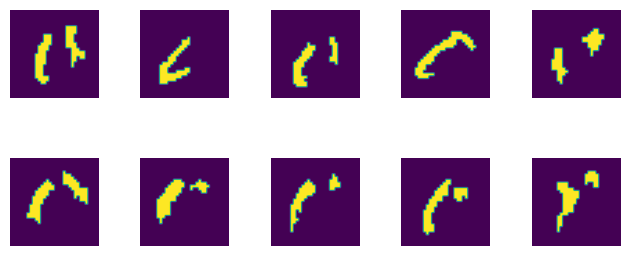

In [9]:
plt.figure()
for i, mask in enumerate(mask_extrcs["zero"]["CNN"][:10]):
    mask = np.array(mask.astype('float32'))
    plt.subplot(2,5, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

print(mask.dtype)
print(mask.shape)

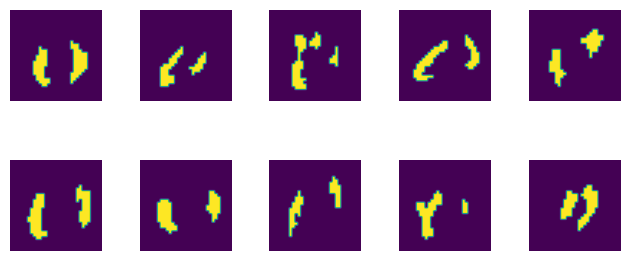

In [13]:
plt.figure()
for i, mask in enumerate(mask_extrcs["zero"]["MobileNetV2"][:10]):
    plt.subplot(2,5, i +1)
    plt.imshow(mask)
    plt.tight_layout()
    plt.axis('off')

In [10]:
# Organize explanations by class
mask_by_class_extrcs          = organize_by_class(mask_extrcs, class_labels, model_extrcs)

# Compute cosine distance between LIME explanations for each class
class_wise_cosine_lime_extrcs = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_labels}

"""
output >>
{
  'zero': {('modelA', 'modelB'): [], ('modelA', 'modelC'): [], ('modelB', 'modelC'): []},
  'one' : {('modelA', 'modelB'): [], ('modelA', 'modelC'): [], ('modelB', 'modelC'): []},
  ...
}
"""

# Compute cosine distance between LIME explanations for each class
for class_name in class_labels:
    img_masks = [mask_extrcs[class_name][model_name] for model_name in model_extrcs] # collect masked explanations
    
    # Pair the masks for each model for the same image
    for img_mask in zip(*img_masks):  # Pair the masks for each model for the same image
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = img_mask[model_extrcs.index(model_i)]
            mask_j        = img_mask[model_extrcs.index(model_j)]
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_extrcs[class_name][(model_i, model_j)].append(co_distance)
            
# a dictionary for storing mean cosine distance between LIME explanations for each class and model pair
distance_dict_lime_extrcs = {}

# Compute mean cosine distance between LIME explanations for each class and model pair
for name in class_labels:
    distance_dict_lime_extrcs[name] = compute_mean_distance_lime(expl_list   = mask_by_class_extrcs[name], 
                                                                 model_names = model_extrcs)

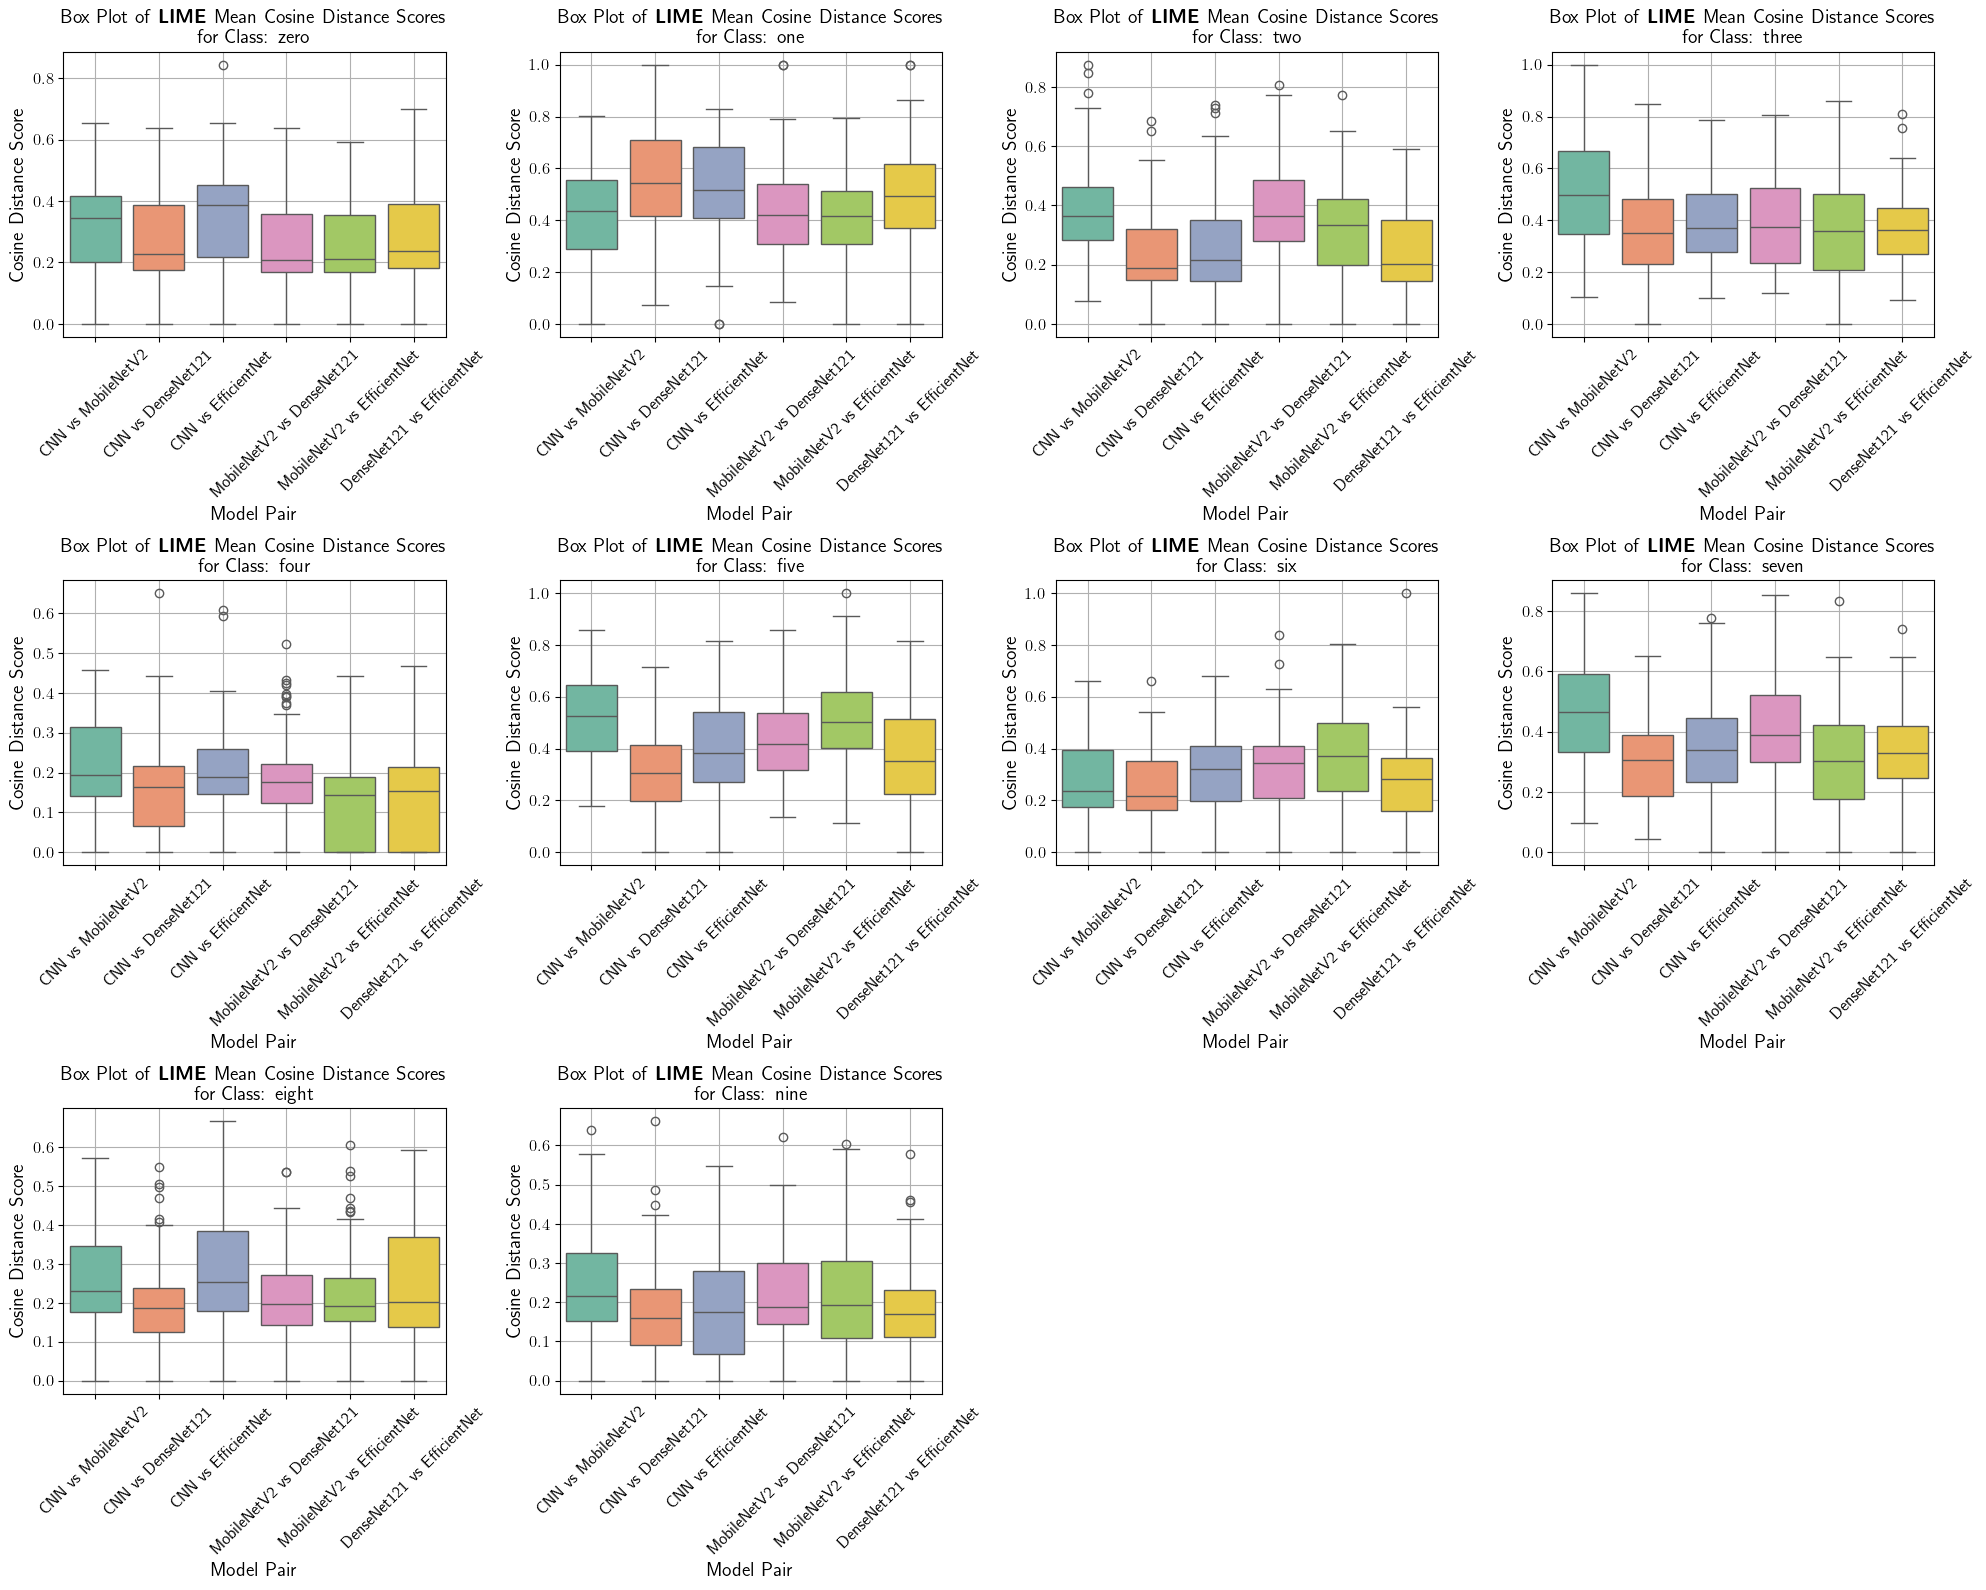

In [10]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_labels, model_extrcs, class_wise_cosine_lime_extrcs, title)

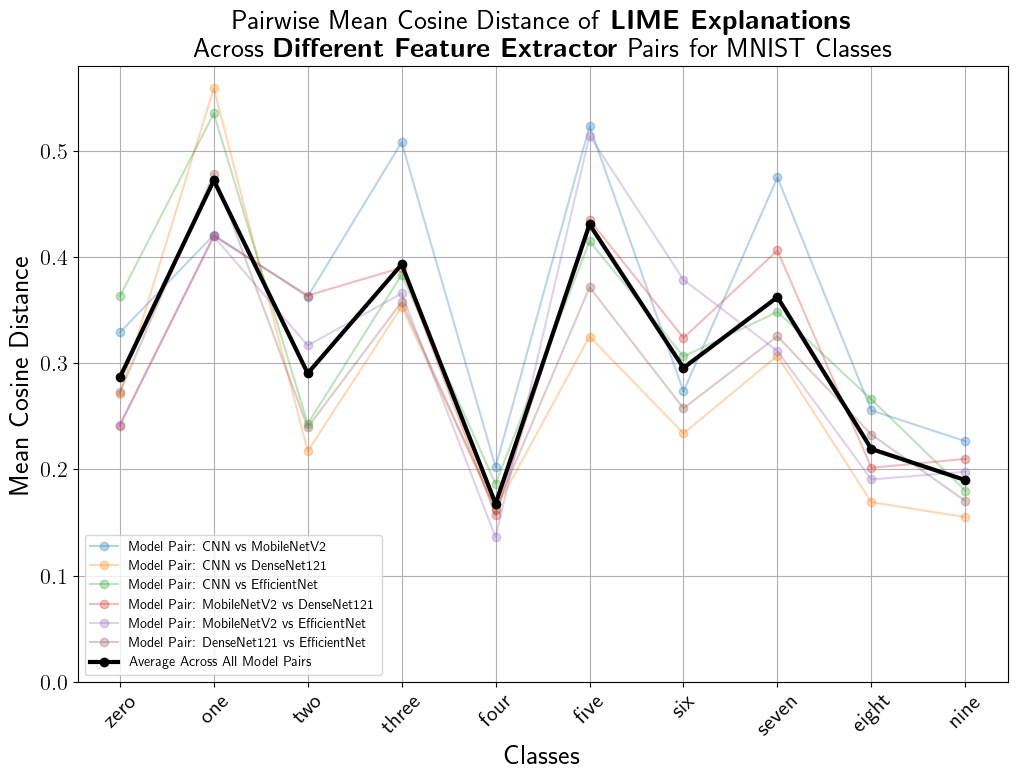

In [11]:
title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations}\nAcross \\textbf{Different Feature Extractor} Pairs for MNIST Classes'
plot_mean_cosine_distance_across_classes(distance_dict_lime_extrcs, class_labels, title)

## Analyze SHAP explanations

In [11]:
# load SHAP data
shap_data_extrcs = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for model_name in model_extrcs:
        file_path = f'SHAP_expls/diff_encoders/explain_{class_idx}_{model_name}-MNIST_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_extrcs[class_name][model_name] = data[:100]                                                  # Select top-100 SHAP explanations for each class and model

In [12]:
print(len(shap_data_extrcs['zero']['CNN']))

100


In [13]:
def visualize_binarized_shap(shap_values):
    print(f"Original SHAP Image Shape             : {shap_values.values[0].shape}") # the last dimention [1] represents the num of expl outputs, used to store the expls for a specific class or output
    binarized_image = apply_threshold_and_binarize(shap_values.values[0])

    print(f"Shape after binarization              : {binarized_image.shape}, dtype : {binarized_image.dtype}")
    print(f"Min pixel value : {np.min(binarized_image)}, Max pixel value: {np.max(binarized_image)}")

    plt.imshow(binarized_image, cmap='gray') 
    plt.colorbar(label="Binarized SHAP Values (0 or 1)")
    plt.title("Binarized SHAP Image")
    plt.axis("off")
    plt.show()


def plot_score_distribution(shap_data, model_name):
    flattened = shap_data.flatten()

    # Plot the distribution using a histogram
    plt.hist(flattened, bins = 50, alpha = 0.7, color = 'blue')
    plt.title(f'Score Distribution for {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

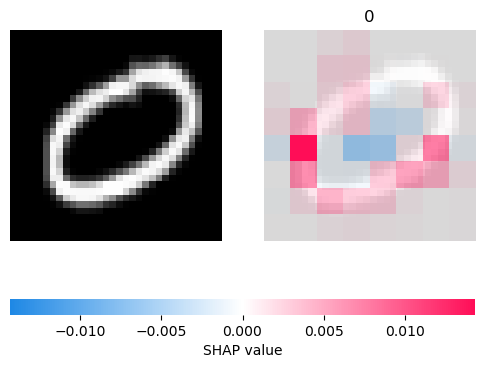

Original SHAP Image Shape             : (32, 32, 3, 1)
Max Positive SHAP Score for Channel 0 : 0.0048
Threshold Value for Channel 0         : 0.0010
Max Positive SHAP Score for Channel 1 : 0.0048
Threshold Value for Channel 1         : 0.0010
Max Positive SHAP Score for Channel 2 : 0.0048
Threshold Value for Channel 2         : 0.0010
Shape after binarization              : (32, 32), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


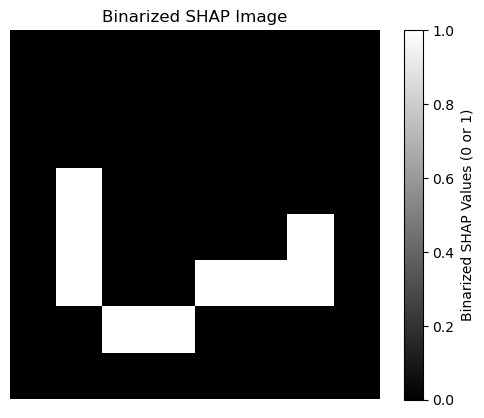

In [43]:
shap_cnn = shap_data_extrcs["zero"]["CNN"][0]
shap.image_plot(shap_cnn)
visualize_binarized_shap(shap_cnn)

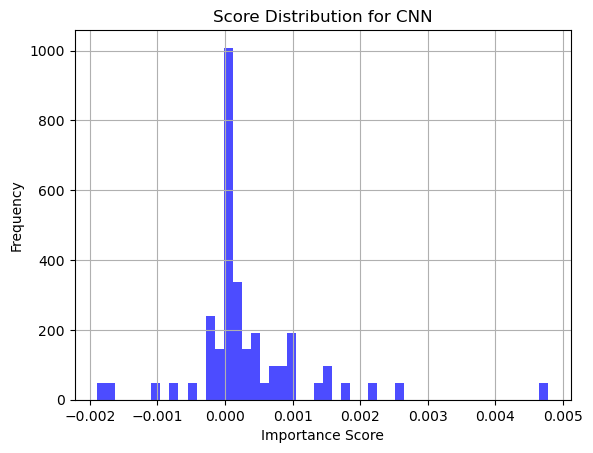

Max Positive SHAP Score for Channel 0 : 0.0048
Threshold Value for Channel 0         : 0.0010
Max Positive SHAP Score for Channel 1 : 0.0048
Threshold Value for Channel 1         : 0.0010
Max Positive SHAP Score for Channel 2 : 0.0048
Threshold Value for Channel 2         : 0.0010


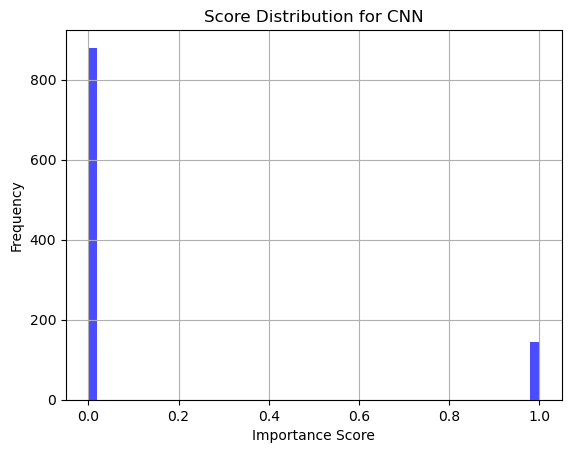

In [18]:
# Score distribution before applying threshold
plot_score_distribution(shap_cnn.values, "CNN")

# Distribution After applying threshold
shap_cnn_threshold = apply_threshold_and_binarize(shap_cnn.values[0])
plot_score_distribution(shap_cnn_threshold, "CNN")

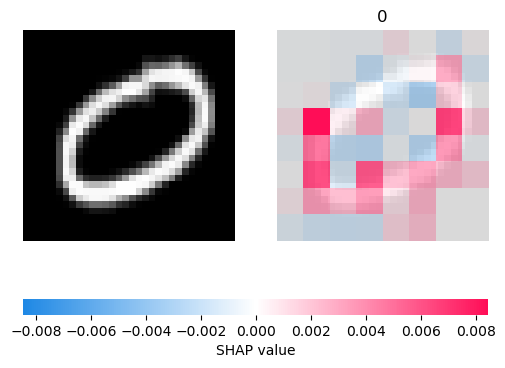

Original SHAP Image Shape             : (32, 32, 3, 1)
Max Positive SHAP Score for Channel 0 : 0.0028
Threshold Value for Channel 0         : 0.0006
Max Positive SHAP Score for Channel 1 : 0.0028
Threshold Value for Channel 1         : 0.0006
Max Positive SHAP Score for Channel 2 : 0.0028
Threshold Value for Channel 2         : 0.0006
Shape after binarization              : (32, 32), dtype : float32
Min pixel value : 0.0, Max pixel value: 1.0


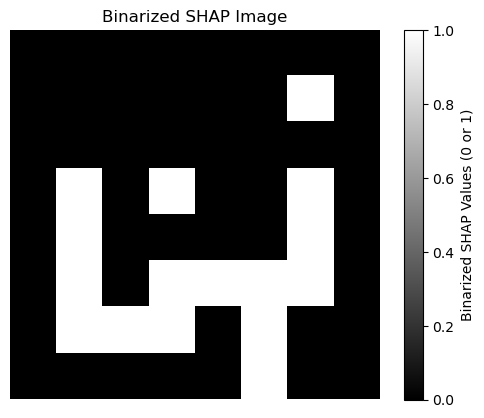

In [19]:
shap_mbnet = shap_data_extrcs["zero"]["MobileNetV2"][0]

shap.image_plot(shap_mbnet)
visualize_binarized_shap(shap_mbnet)

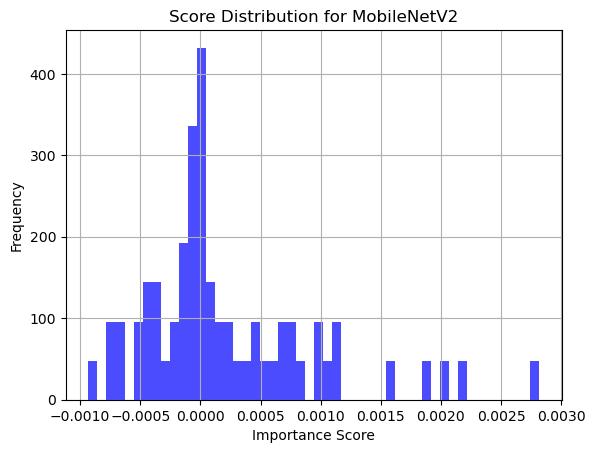

Max Positive SHAP Score for Channel 0 : 0.0028
Threshold Value for Channel 0         : 0.0006
Max Positive SHAP Score for Channel 1 : 0.0028
Threshold Value for Channel 1         : 0.0006
Max Positive SHAP Score for Channel 2 : 0.0028
Threshold Value for Channel 2         : 0.0006


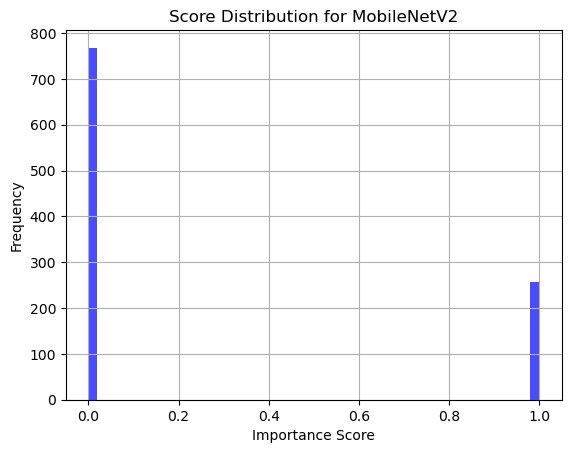

In [21]:
# Score distribution before applying threshold
plot_score_distribution(shap_mbnet.values, "MobileNetV2")

# Distribution After applying threshold
shap_mbnet_threshold = apply_threshold_and_binarize(shap_mbnet.values[0])
plot_score_distribution(shap_mbnet_threshold, "MobileNetV2")

In [18]:
flatten_shap_cnn   = shap_cnn_threshold.flatten()
flatten_shap_mbnet = shap_mbnet_threshold.flatten()

cnn_mbnet          = cosine_similarity(flatten_shap_cnn.reshape(1,-1), flatten_shap_mbnet.reshape(1,-1))[0][0]
print(f"Cosine Similarity of CNN-MobileNetV2 for the instance : {cnn_mbnet}")

In [13]:
# Organize SHAP data by class
shap_by_class_extrcs          = organize_by_class(shap_data_extrcs, class_labels, model_extrcs)

# Compute cosine distance between SHAP explanations for each class
class_wise_cosine_shap_extrcs = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_labels}
"""
output structure would look like >>
{
  'zero': {('modelA', 'modelB'): [], ('modelA', 'modelC'): [], ('modelB', 'modelC'): []},
  ...
  }
"""

# Compute cosine distance between SHAP explanations for each class
for class_name in class_labels:
    shap_values = [shap_data_extrcs[class_name][model_name] for model_name in model_extrcs]               # Get shap explanations for each model
    
    for shap_value in zip(*shap_values):                                                                  # Pair the masks for each model for the same image
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = shap_value[model_extrcs.index(model_i)]
            mask_j        = shap_value[model_extrcs.index(model_j)]
            co_distance   = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_extrcs[class_name][(model_i, model_j)].append(co_distance) 

distance_dict_shap_extrcs = {}

for name in class_labels:
    distance_dict_shap_extrcs[name] = compute_mean_distance_shap(expl_list   = shap_by_class_extrcs[name], 
                                                                 model_names = model_extrcs)

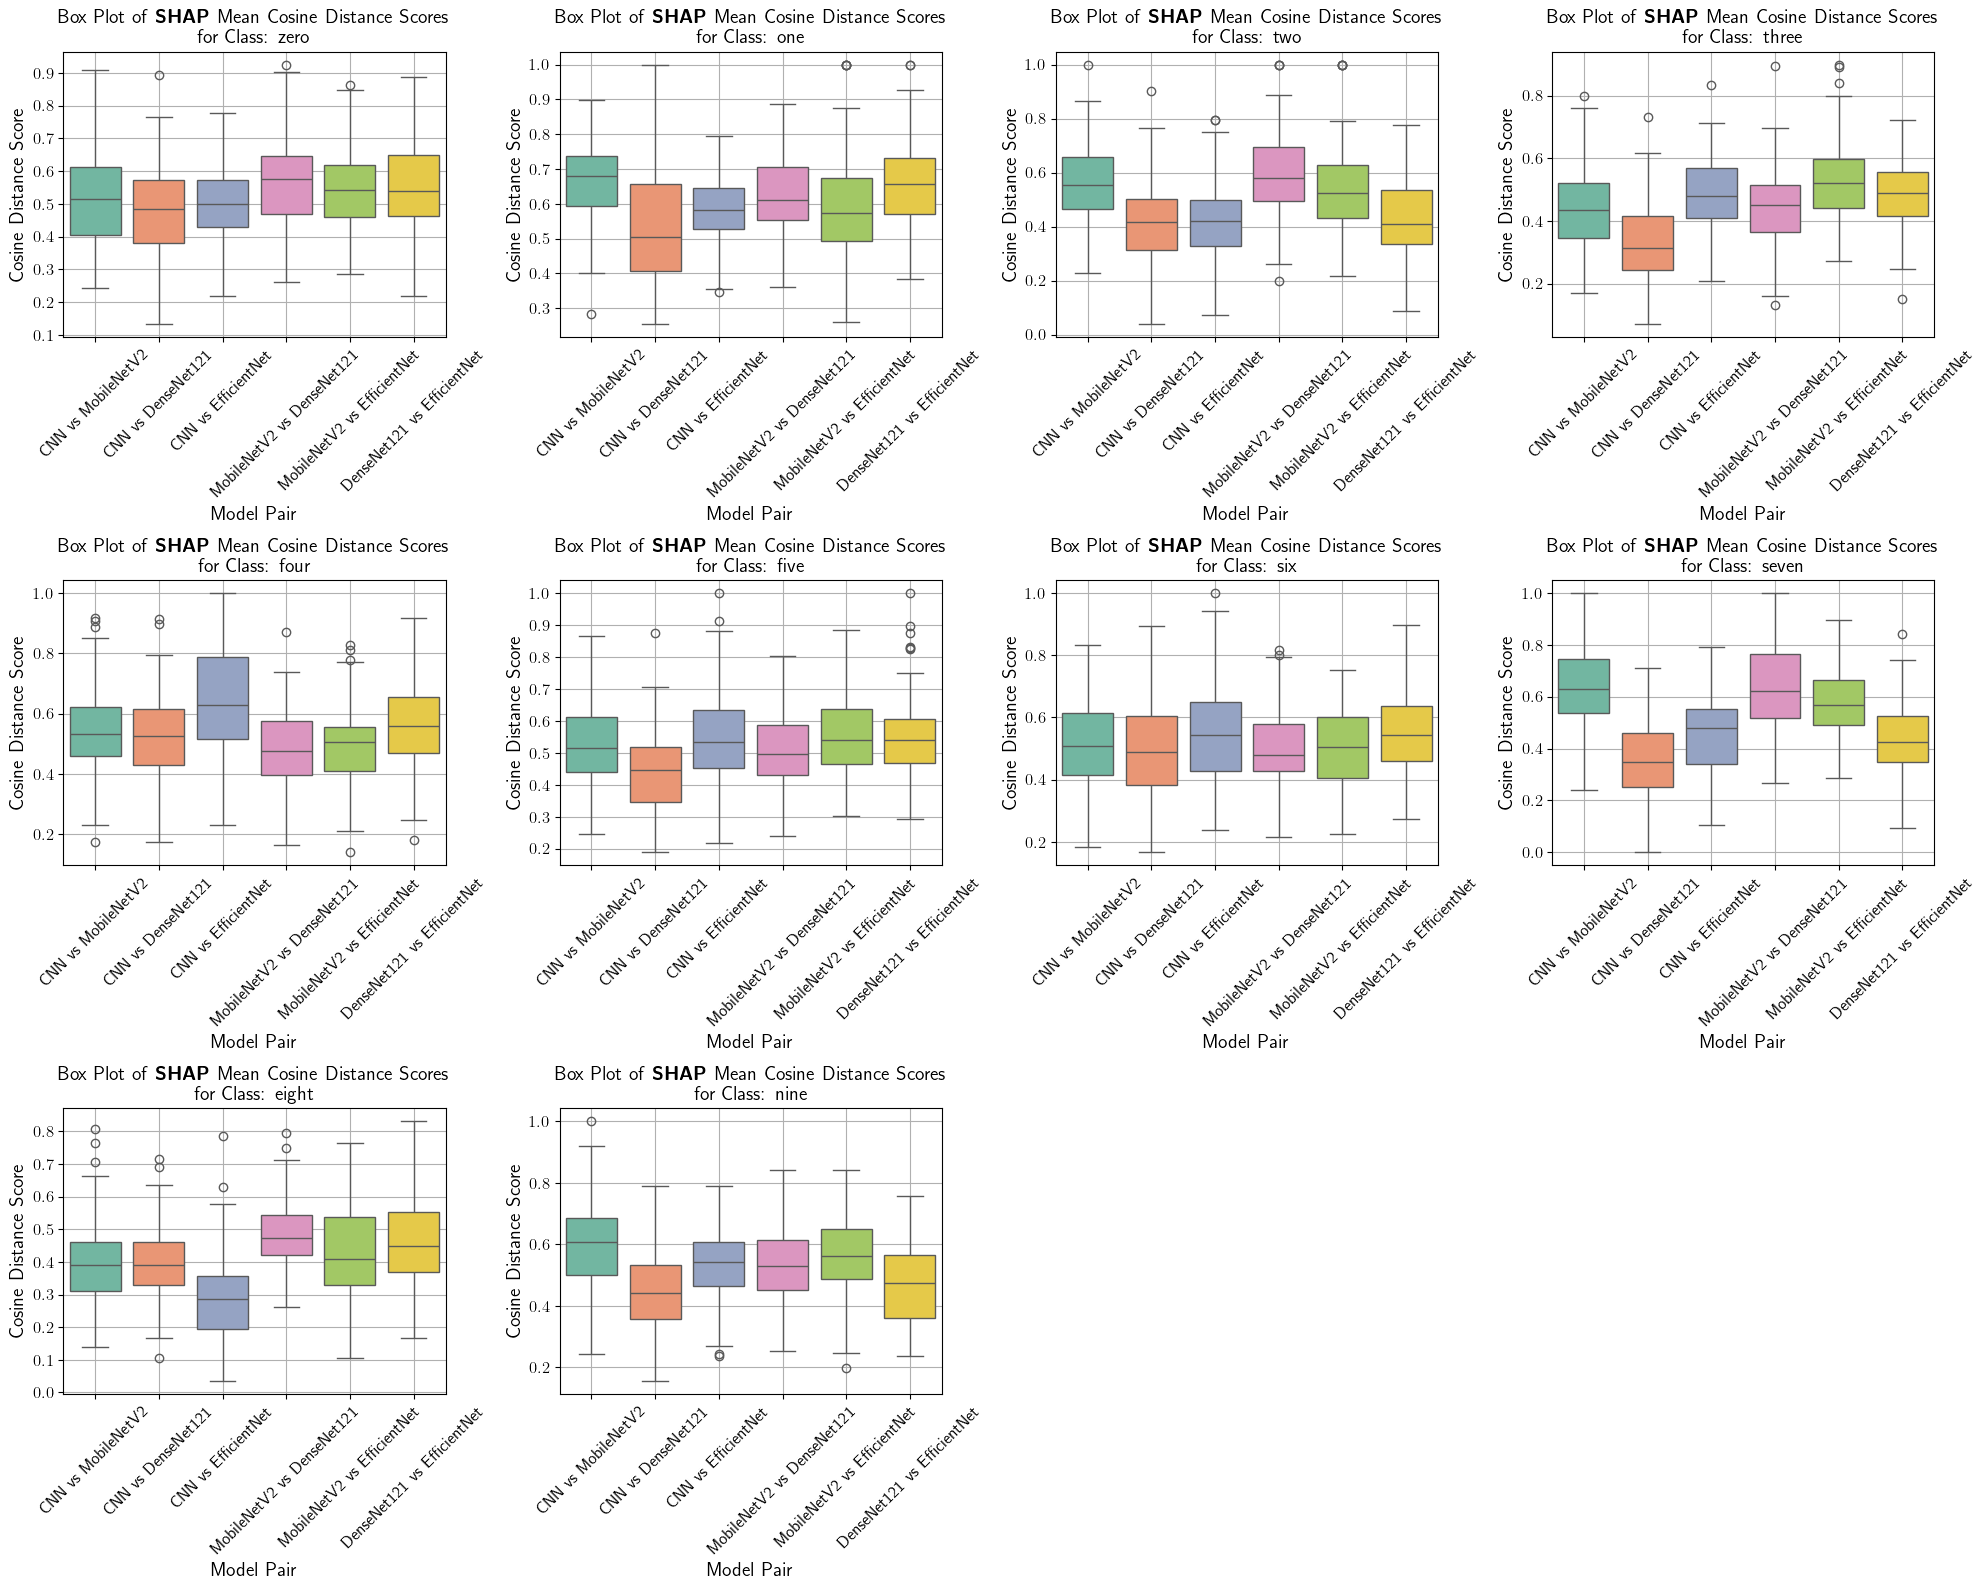

In [21]:
title = "Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\nfor Class"
plot_class_wise_cosine_distances(class_labels, model_extrcs, class_wise_cosine_shap_extrcs, title)

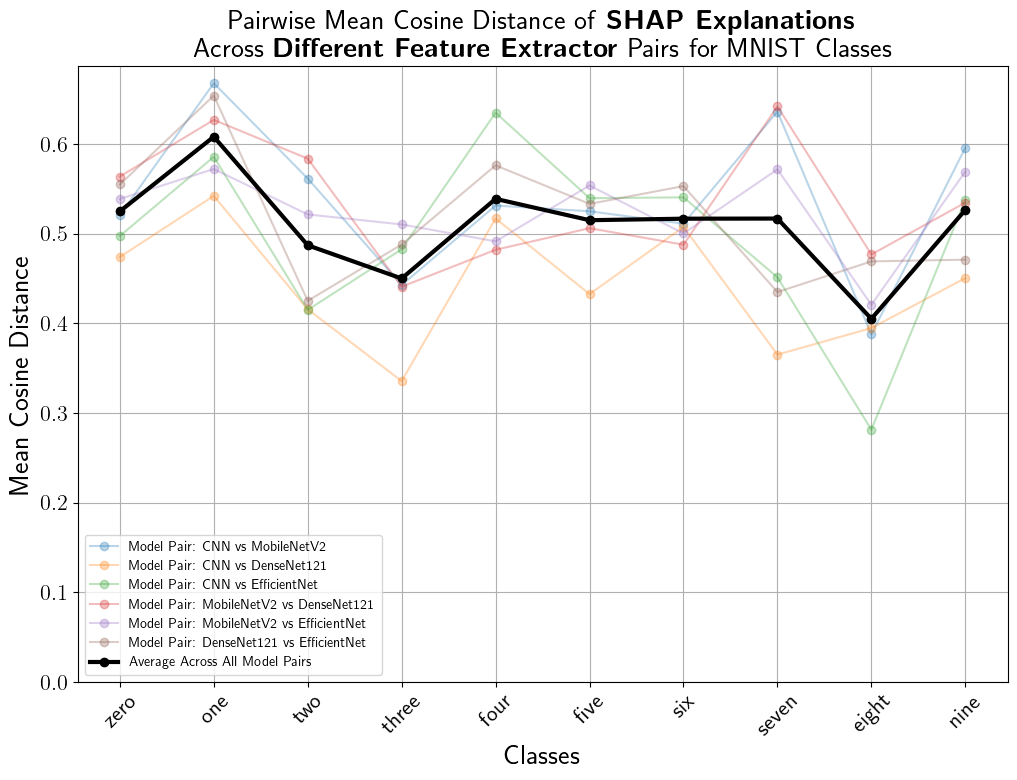

In [52]:
title = 'Pairwise Mean Cosine Distance of \\textbf{SHAP Explanations} \nAcross \\textbf{Different Feature Extractor} Pairs for MNIST Classes'
plot_mean_cosine_distance_across_classes(distance_dict_shap_extrcs, class_labels, title)

# Analyzing Explanations for models (CNN architecture) with different optimziers

In [14]:
model_opts = ["CNN-SGD", "CNN-Adam", "CNN-Nadam", "CNN-RMSprop"]        # model names

In [15]:
# load LIME data of different optimizers
mask_opts      = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for model_opt in model_opts:
        
        file_path = f'LIME_expls/diff_optimizers/explain_{class_idx}_{model_opt}.pkl'

        with open(file_path, 'rb') as file:
            temp_opt, mask_opt, _        = pickle.load(file)

        mask_opts[class_name][model_opt] = mask_opt

In [16]:
print(len(mask_opts['zero']['CNN-SGD']))

100


In [17]:
# organize by class
mask_by_class_opt          = organize_by_class(mask_opts, class_labels, model_opts)

class_wise_cosine_lime_opt = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_labels}

for class_name in class_labels:
    img_masks = [mask_opts[class_name][model_opt] for model_opt in model_opts]
    
    for img_mask in zip(*img_masks):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i        = img_mask[model_opts.index(opt_i)]
            mask_j        = img_mask[model_opts.index(opt_j)]
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_opt[class_name][(opt_i, opt_j)].append(co_distance)
            
distance_dict_lime_opts = {}

for name in class_labels:
    distance_dict_lime_opts[name]= compute_mean_distance_lime(expl_list   = mask_by_class_opt[name], 
                                                             model_names = model_opts)

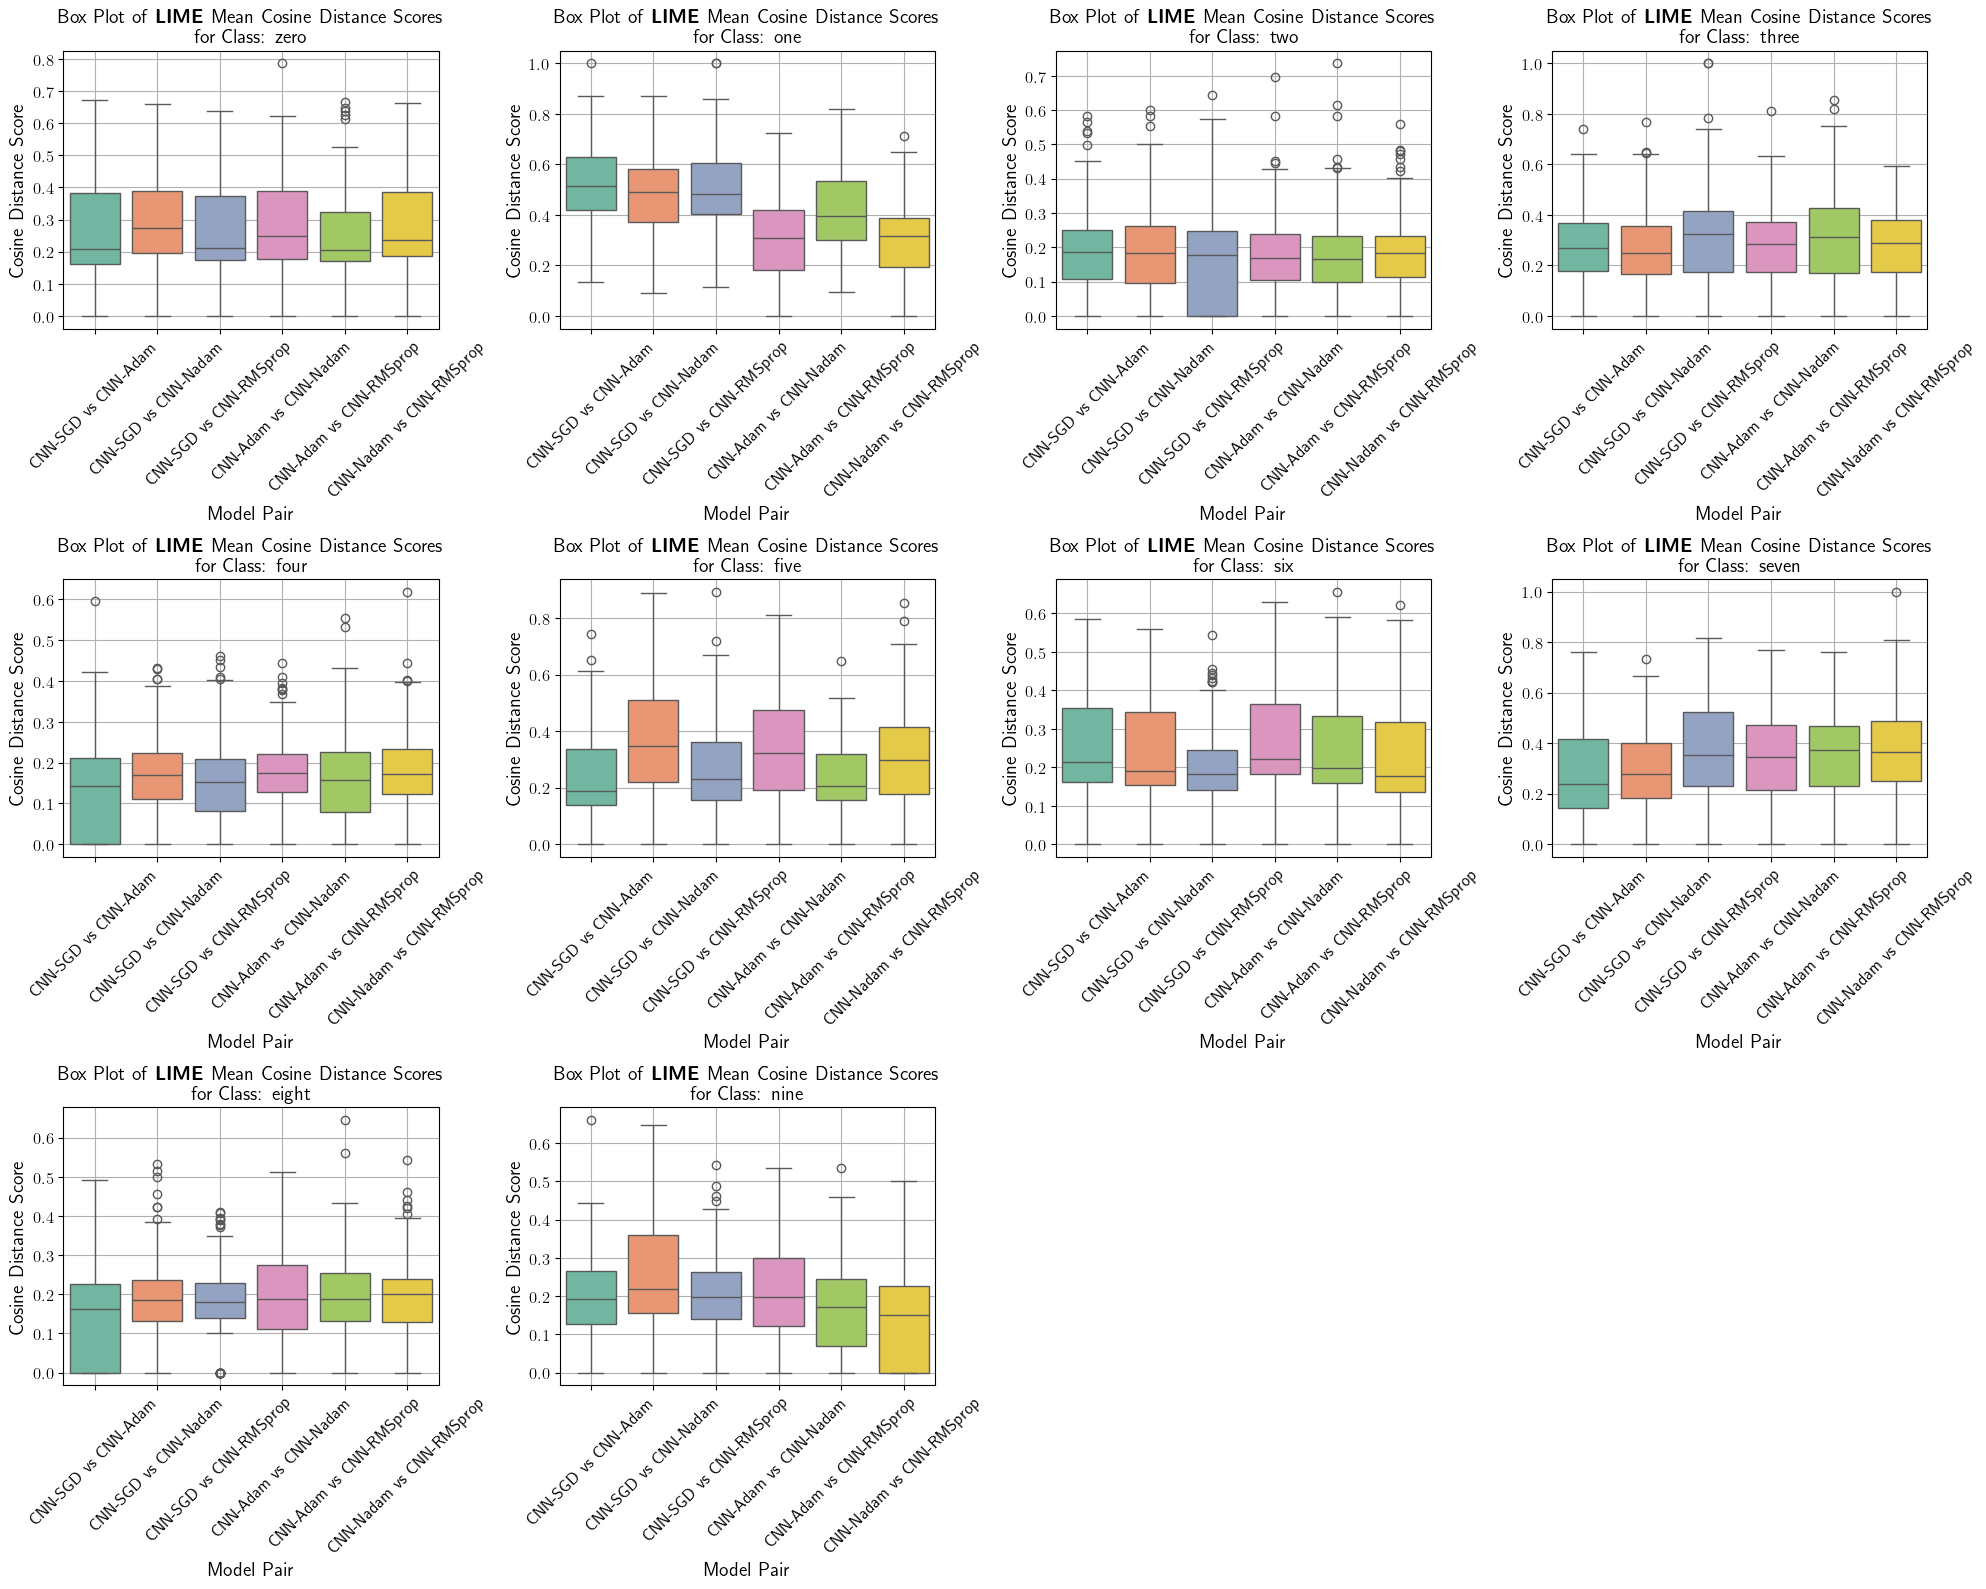

In [26]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_labels, model_opts, class_wise_cosine_lime_opt, title)

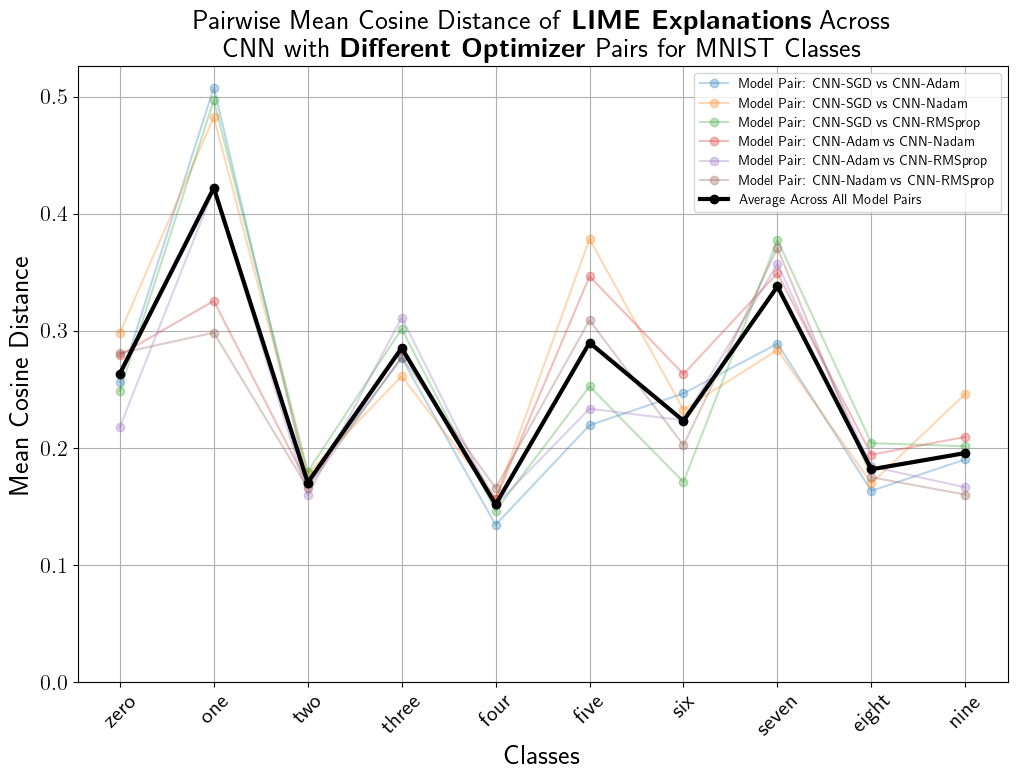

In [16]:
title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations} Across\n CNN with \\textbf{Different Optimizer} Pairs for MNIST Classes' 
plot_mean_cosine_distance_across_classes(distance_dict_lime_opts, class_labels, title)

In [18]:
# load SHAP data
shap_data_opts = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for model_opt in model_opts:
        
        file_path = f'SHAP_expls/diff_optimizers/explain_{class_idx}_{model_opt}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_opts[class_name][model_opt] = data[:100]

In [19]:
print(len(shap_data_opts['zero']['CNN-SGD']))

100


In [20]:
shap_by_class_opts          = organize_by_class(shap_data_opts, class_labels, model_opts)

class_wise_cosine_shap_opts = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_labels}

for class_name in class_labels:
    shap_values         = [shap_data_opts[class_name][model_opt] for model_opt in model_opts]
    
    for shap_value in zip(*shap_values):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i      = shap_value[model_opts.index(opt_i)]
            mask_j      = shap_value[model_opts.index(opt_j)]
            co_distance = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_opts[class_name][(opt_i, opt_j)].append(co_distance) 

distance_dict_shap_opts  = {}

for name in class_labels:
    distance_dict_shap_opts[name] = compute_mean_distance_shap(expl_list   = shap_by_class_opts[name],
                                                               model_names = model_opts)

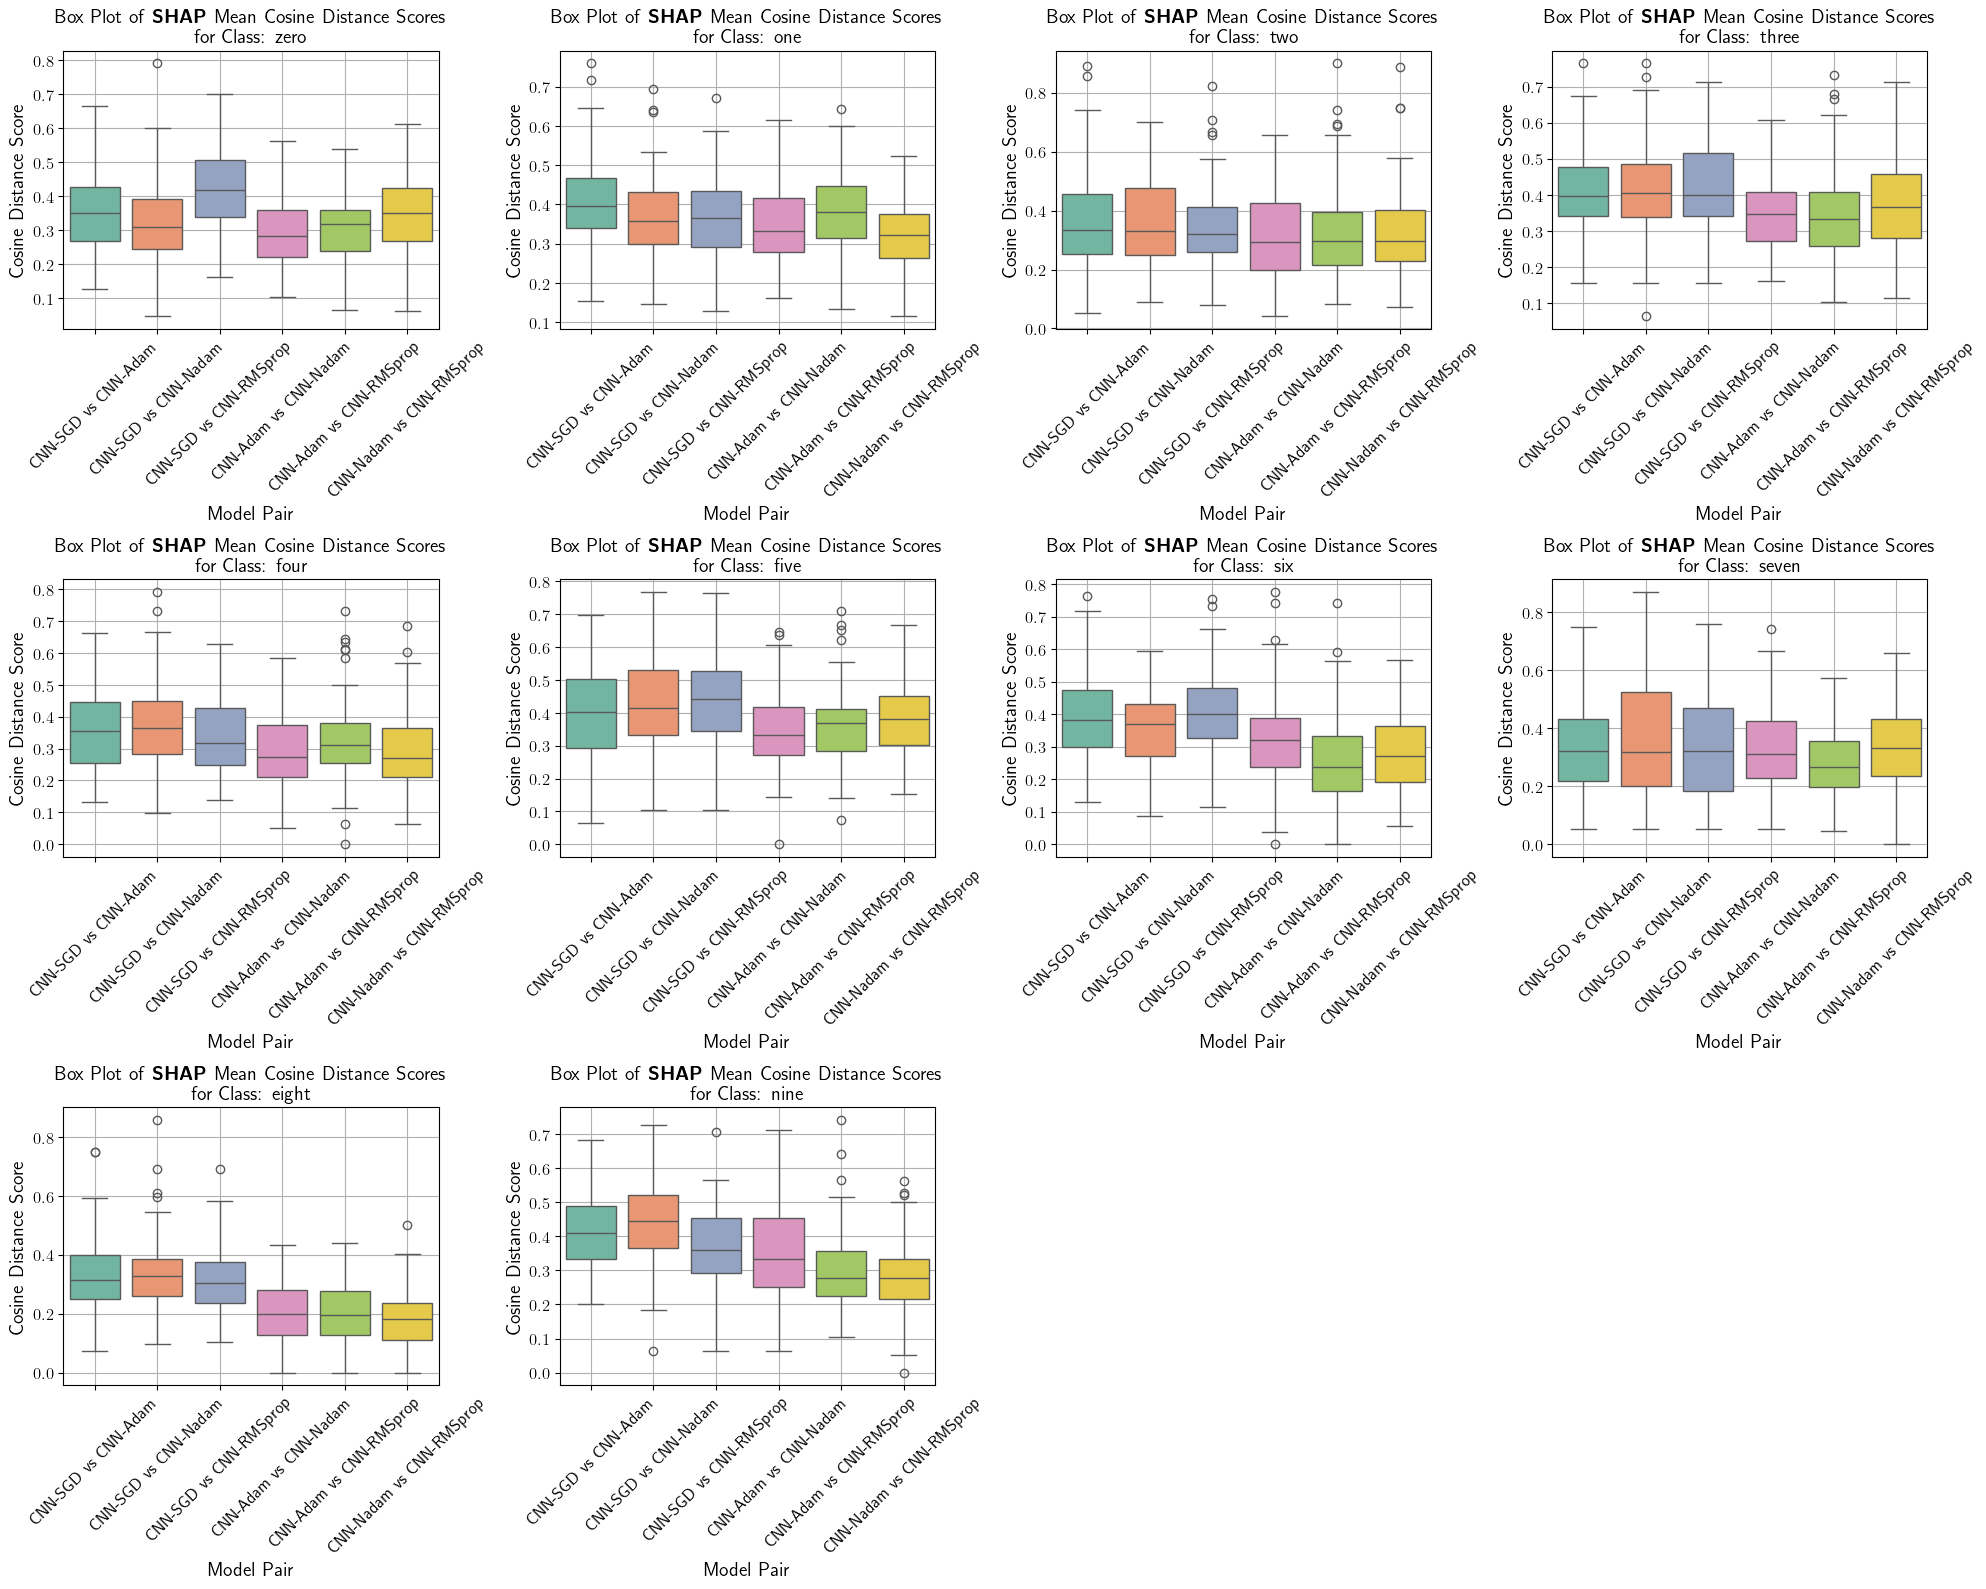

In [81]:
title = 'Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_labels, model_opts, class_wise_cosine_shap_opts, title)

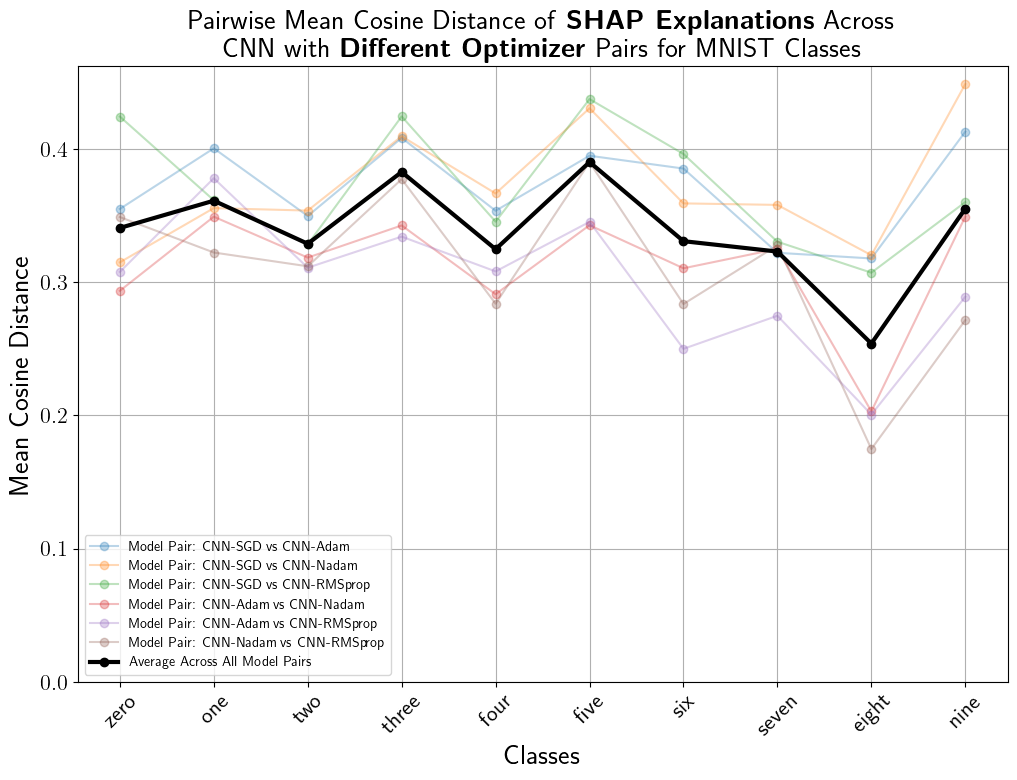

In [82]:
title = 'Pairwise Mean Cosine Distance of \\textbf{SHAP Explanations} Across\n CNN with \\textbf{Different Optimizer} Pairs for MNIST Classes'
plot_mean_cosine_distance_across_classes(distance_dict_shap_opts, class_labels, title)

In [21]:
model_seeds = []

for i in range(10):
    seed = f'CNN{i+1}'
    model_seeds.append(seed)

In [22]:
# load LIME data of different optimizers
mask_seeds      = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for model_seed in model_seeds:
        
        file_path = f'LIME_expls/diff_seeds/explain_{class_idx}_{model_seed}.pkl'

        with open(file_path, 'rb') as file:
            _, mask_seed, _       = pickle.load(file)
            
        mask_seeds[class_name][model_seed] = mask_seed

In [32]:
print(len(mask_seeds["zero"]["CNN1"]))

100


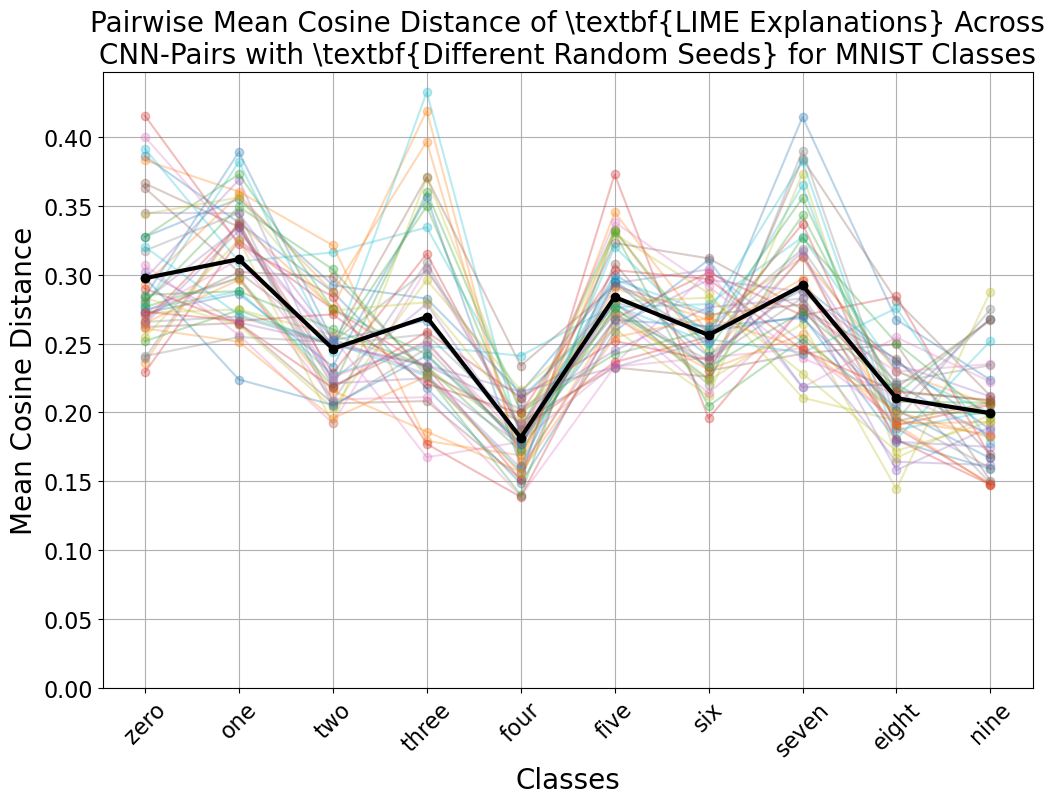

In [23]:
# organize by class
mask_by_class_seeds          = organize_by_class(mask_seeds, class_labels, model_seeds)

distance_dict_lime_seeds = {}

for name in class_labels:
    distance_dict_lime_seeds[name] = compute_mean_distance_lime(expl_list   = mask_by_class_seeds[name],
                                                                model_names = model_seeds)

# Since we have 10 CNNs, it is difficult to display box-plots of all 10 CNNs. Hence, we skip as previous results can help us understand the performance of CNN over MNIST.

title = 'Pairwise Mean Cosine Distance of \\textbf{LIME Explanations} Across\nCNN-Pairs with \\textbf{Different Random Seeds} for MNIST Classes'
plot_mean_cosine_distance_across_classes(distance_dict_lime_seeds, class_labels, title, show_legend = False)

In [24]:
# load SHAP data
shap_data_seeds = {class_name: {} for class_name in class_labels}

for class_idx, class_name in enumerate(class_labels):
    for model_seed in model_seeds:
        
        file_path = f'SHAP_expls/diff_seeds/explain_{class_idx}_{model_seed}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_seeds[class_name][model_seed] = data[:100]

In [25]:
print(len(shap_data_seeds['zero']['CNN1']))

100


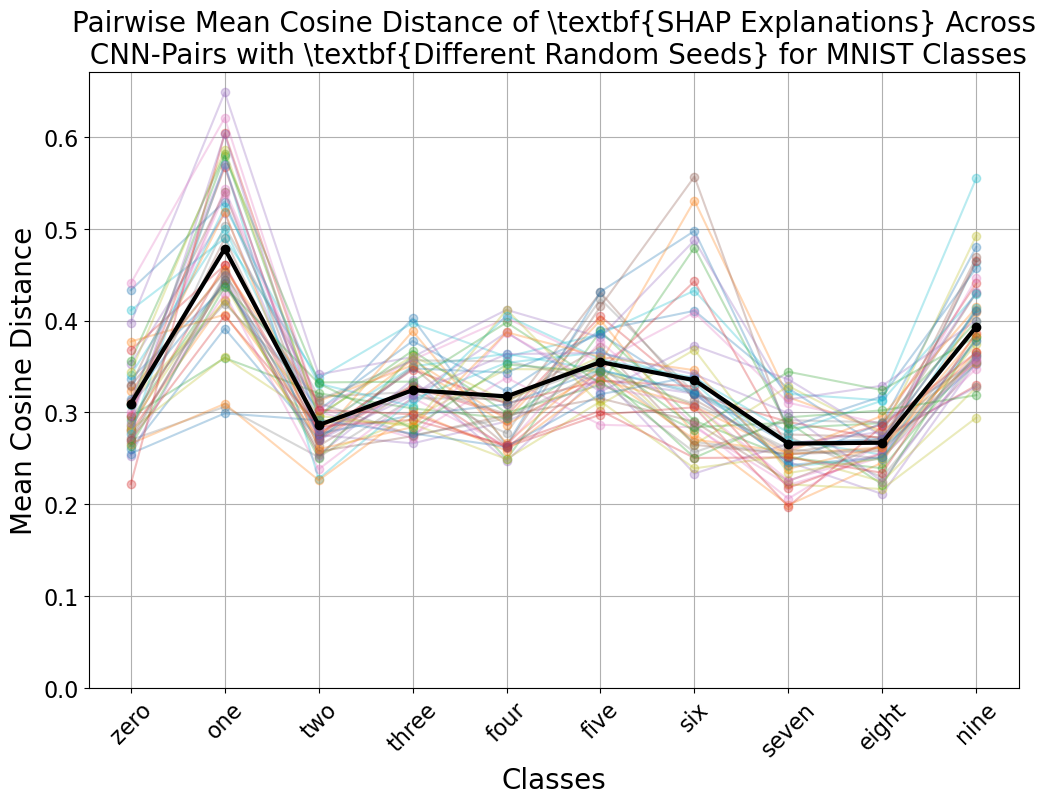

In [26]:
shap_by_class_seeds          = organize_by_class(shap_data_seeds, class_labels, model_seeds)

distance_dict_shap_seeds     = {}
for name in class_labels:
    distance_dict_shap_seeds[name] = compute_mean_distance_shap(expl_list   = shap_by_class_seeds[name],
                                                                model_names = model_seeds)

title = 'Pairwise Mean Cosine Distance of \\textbf{SHAP Explanations} Across\n CNN-Pairs with \\textbf{Different Random Seeds} for MNIST Classes'
plot_mean_cosine_distance_across_classes(distance_dict_shap_seeds, class_labels, title, show_legend = False)

In [27]:
# Extract average model pair-wise cosine distance scores for each class 
def extract_average_score(mean_cosine_scores, classes = class_labels):      
    model_pair    = list(mean_cosine_scores[class_labels[0]].keys())                    # model pair
    average_score = []
    
    # Compute average cosine distance across classes for each model pair
    for class_name in classes:
        score     = np.mean([mean_cosine_scores[class_name][pair] for pair in model_pair])      # compute average cosine distance across classes for each model pair
        average_score.append(score)

    return average_score

## Average class-level scores across mnist classes

## 1. 
### I. Average LIME explanation variations across mnist classes:
Average_Class_Score = {cosine_dis(m1_, m_2) + ... + cosine_dis(m_i, m_j)} / total number of model

In [28]:
# Compute average cosine distance scores for each class and model pair
avg_model_extrcs_lime   = extract_average_score(distance_dict_lime_extrcs)          # Average cosine distance scores for LIME explanations across models with different feature extractor (CNN, Mobilenet, DenseNet, Effinet) pairs
avg_model_opts_lime     = extract_average_score(distance_dict_lime_opts)            # Average cosine distance scores for LIME explanations across models (CNN) with different optimizer pairs
avg_model_seeds_lime    = extract_average_score(distance_dict_lime_seeds)           # Average cosine distance scores for LIME explanations across models (CNN) with different random seed pairs

In [29]:
# save the results in a dataframe
data_lime = {
    'Class'            : class_labels,
    'diff extractors'  : avg_model_extrcs_lime,
    'diff optmizers'   : avg_model_opts_lime,
    'diff seeds'       : avg_model_seeds_lime,
}

df_lime = pd.DataFrame(data_lime)
print(df_lime)

   Class  diff extractors  diff optmizers  diff seeds
0   zero         0.286659        0.263322    0.297506
1    one         0.472214        0.421904    0.311322
2    two         0.290543        0.170150    0.246231
3  three         0.393133        0.285208    0.269310
4   four         0.167685        0.151504    0.181711
5   five         0.430800        0.289730    0.283878
6    six         0.295687        0.222977    0.256228
7  seven         0.362299        0.337752    0.292252
8  eight         0.219306        0.181548    0.210333
9   nine         0.190000        0.195429    0.199475


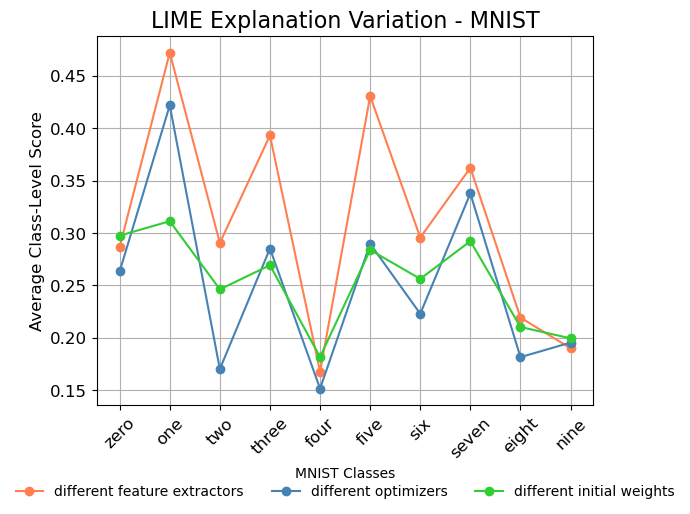

In [30]:
# Plot the average cosine distance scores for LIME explanations
extrcs_plot_lime,  = plt.plot(class_labels, avg_model_extrcs_lime, marker = 'o', color = 'coral', label   = 'different feature extractors')  # pair-wise average score for models with different feature extractors
opts_plot_lime,    = plt.plot(class_labels, avg_model_opts_lime, marker   = 'o', color = '#4682B4', label = 'different optimizers')          # pair-wise average score for models (CNN) with different optimizers
seeds_plot_lime,   = plt.plot(class_labels, avg_model_seeds_lime, marker  = 'o', color = '#32CD32', label = 'different initial weights')     # pair-wise average score for models (CNN) with different weight initializations

plt.legend(
    handles        = [extrcs_plot_lime, opts_plot_lime, seeds_plot_lime], #, 
    loc            = 'upper center',
    bbox_to_anchor = (0.5,-0.18),
    framealpha     = 0.0,
    ncol           = 3
)

# ax = plt.gca()
# ax.set_facecolor('#004C43')
# plt.gcf().set_facecolor('#cec1b3')

plt.title("LIME Explanation Variation - MNIST", fontsize=16)
plt.xlabel("MNIST Classes")
plt.ylabel("Average Class-Level Score", fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

In [44]:
class_labels

['zero',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine']

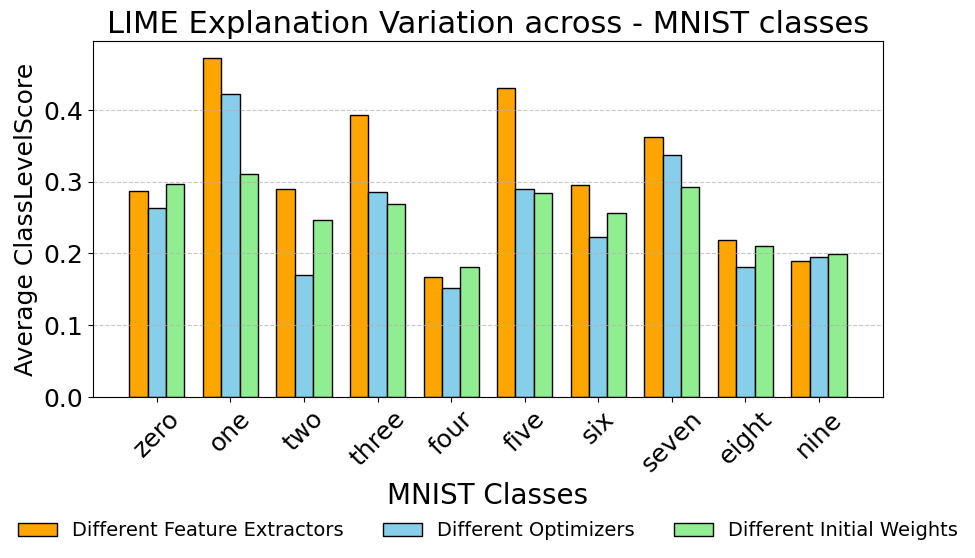

In [33]:
# Bar plot
x       = np.arange(len(class_labels))
width   = 0.25  # Bar width
fig, ax = plt.subplots(figsize=(10, 6))

extrcs_bar = ax.bar(x - width, avg_model_extrcs_lime, width, label='Different Feature Extractors', color='orange',edgecolor='black')
opts_bar   = ax.bar(x, avg_model_opts_lime, width, label='Different Optimizers', color='skyblue', edgecolor='black')
seeds_bar  = ax.bar(x + width, avg_model_seeds_lime, width, label='Different Initial Weights', color='lightgreen', edgecolor='black')

ax.set_title("LIME Explanation Variation across - MNIST classes", fontsize=22)
ax.set_xlabel("MNIST Classes", fontsize=20)
ax.set_ylabel("Average ClassLevelScore", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), framealpha=0.0, ncol=3, fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [34]:
avg_model_extrcs_shap = extract_average_score(distance_dict_shap_extrcs)       # Average cosine distance scores for SHAP explanations across models with different feature extractors
avg_model_opts_shap   = extract_average_score(distance_dict_shap_opts          # Average cosine distance scores for SHAP explanations across models with different optimizers
avg_model_seeds_shap  = extract_average_score(distance_dict_shap_seeds)        # Average cosine distance scores for SHAP explanations across models with different weight initializations

In [35]:
data_shap = {
    'Class'            : class_labels,
    'diff extractors'  : avg_model_extrcs_shap,
    'diff optmizers'   : avg_model_opts_shap,
    'diff seeds'       : avg_model_seeds_shap,
}

df_shap  = pd.DataFrame(data_shap)
print(df_shap)

   Class  diff extractors  diff optmizers  diff seeds
0   zero         0.524732        0.340635    0.309538
1    one         0.607949        0.361079    0.478162
2    two         0.486885        0.328763    0.286031
3  three         0.449825        0.382633    0.324166
4   four         0.538650        0.324670    0.317349
5   five         0.514846        0.390052    0.354694
6    six         0.516523        0.330696    0.335022
7  seven         0.516678        0.322892    0.265968
8  eight         0.404863        0.253868    0.266939
9   nine         0.526304        0.355172    0.393179


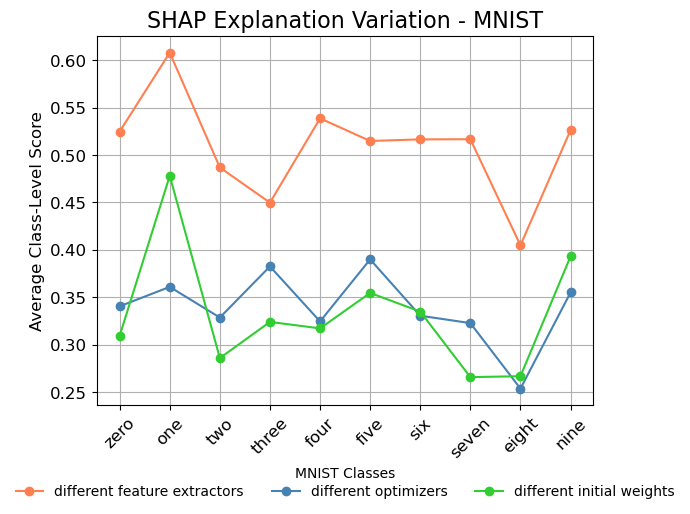

In [36]:
extrcs_plot_shap,  = plt.plot(class_labels, avg_model_extrcs_shap, marker = 'o', color = 'coral', label   = 'different feature extractors')
opts_plot_shap,    = plt.plot(class_labels, avg_model_opts_shap, marker   = 'o', color = '#4682B4', label = 'different optimizers')
seeds_plot_shap,   = plt.plot(class_labels, avg_model_seeds_shap, marker  = 'o', color = '#32CD32', label = 'different initial weights')

plt.legend(
    handles        = [extrcs_plot_shap, opts_plot_shap, seeds_plot_shap],
    loc            = 'upper center',
    bbox_to_anchor = (0.5,-0.18),
    framealpha     = 0.0,
    ncol           = 3
)

plt.title("SHAP Explanation Variation - MNIST", fontsize=16)
plt.xlabel("MNIST Classes")
plt.ylabel("Average Class-Level Score", fontsize=12)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

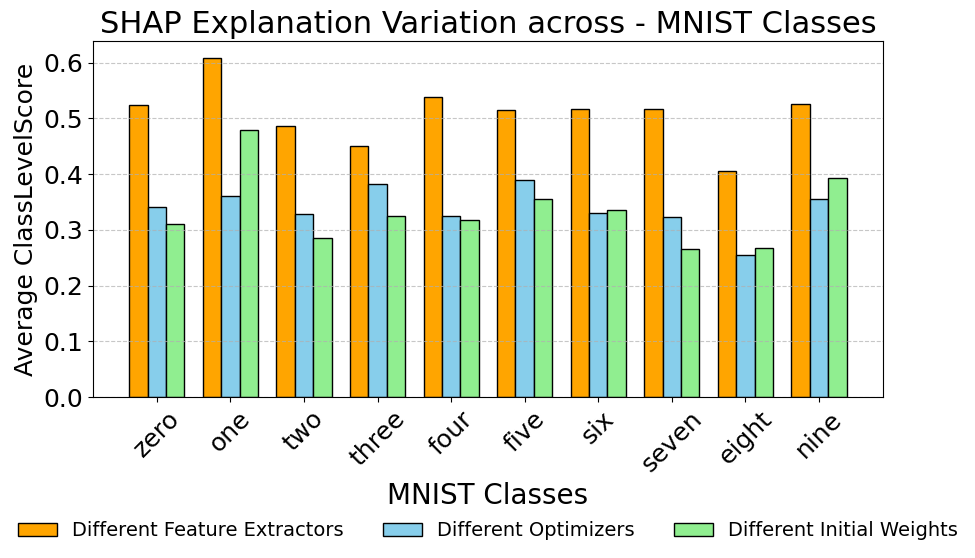

In [38]:
x       = np.arange(len(class_labels))
width   = 0.25  # Bar width
fig, ax = plt.subplots(figsize=(10, 6))

extrcs_bar = ax.bar(x - width, avg_model_extrcs_shap, width, label='Different Feature Extractors', color='orange',edgecolor='black')
opts_bar   = ax.bar(x, avg_model_opts_shap, width, label='Different Optimizers', color='skyblue', edgecolor='black')
seeds_bar  = ax.bar(x + width, avg_model_seeds_shap, width, label='Different Initial Weights', color='lightgreen',edgecolor='black')

ax.set_title("SHAP Explanation Variation across - MNIST Classes", fontsize=22)
ax.set_xlabel("MNIST Classes", fontsize=20)
ax.set_ylabel("Average ClassLevelScore", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), framealpha=0.0, ncol=3, fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()